# Intro

In [1]:
# Data
import os
import numpy as np
import pandas as pd

# SkLearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Display
from IPython.display import clear_output

# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

# Redes Neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Input, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# Gradient Boosting
import xgboost as xgb

# Import/Export
import pickle
import joblib

# Optimización Inversa
from scipy.optimize import differential_evolution, minimize

In [2]:
REPO_NAME = "Multi-Parameter_Wireless_Network"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/MiguelMussi/{REPO_NAME}.git
  os.chdir(REPO_NAME)

Cloning into 'Multi-Parameter_Wireless_Network'...
remote: Enumerating objects: 321, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 321 (delta 104), reused 63 (delta 43), pack-reused 159
Receiving objects: 100% (321/321), 25.74 MiB | 15.60 MiB/s, done.
Resolving deltas: 100% (144/144), done.


Establecer GPU por defecto en caso de estar disponible.

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
with open('datos.txt', 'r') as file:
    data = file.read()
lines = data.strip().split('\n')
rows = [line.split() for line in lines]
df = pd.DataFrame(rows)
df = df.apply(pd.to_numeric)

In [5]:
df.shape

(13800, 227)

### Funciones

In [6]:
def renombrar_columnas(df):
    new_col_names = []
    for i in range(1, 57):
        new_col_names.extend([f'{i}a', f'{i}b', f'{i}c', f'{i}d'])
    new_col_names.extend(['R1', 'R2', 'R3'])
    df.columns = new_col_names
    return df

In [7]:
def eliminar_registros_duplicados(df):
    df_clean = df.drop_duplicates()
    return df_clean

In [8]:
def escalar_datos(df, scaler_dict=None):
    if scaler_dict is None:
        scaler_dict = {}
    for columna in df.columns:
        if columna not in scaler_dict:
            scaler_dict[columna] = MinMaxScaler()
        df[columna] = scaler_dict[columna].fit_transform(df[[columna]])
    return df, scaler_dict

In [9]:
def separar_Xy(df, columnas_target):
    X = df.drop(columnas_target, axis=1).copy()
    y = df[columnas_target].copy()
    return X, y

In [10]:
def r2_ajustado(y_true, y_pred, n, p):
    r2 = r2_score(y_true, y_pred)
    r2_aj = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return r2_aj

### Procesamiento

In [11]:
df = renombrar_columnas(df)
df = eliminar_registros_duplicados(df)

In [12]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)

In [13]:
df_train, train_scaler_dict = escalar_datos(df_train)

In [14]:
columnas_target = ['R1', 'R2', 'R3']

In [15]:
X_train, y_train = separar_Xy(df_train, columnas_target=columnas_target)

In [16]:
df_test_out = df_test.copy()
df_test_out, _ = escalar_datos(df_test_out, train_scaler_dict)
X_test, y_test = separar_Xy(df_test_out, columnas_target=columnas_target)

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10258, 224), (10258, 3), (2565, 224), (2565, 3))

# Ensamble

## MLP Model

In [18]:
mlp_model = MLPRegressor(hidden_layer_sizes=(500, 200, 100, 50, 10 ), activation='relu', solver='adam', max_iter=300)
mlp_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(500, 200, 100, 50, 10), max_iter=300)

## DNN Model

In [20]:
# Arquitectura
# dnn_model = Sequential([
#     Input(shape=(X_train.shape[1],)),
#     Dense(256, activation='relu'), Dropout(0.2),
#     Dense(32, activation='relu'), Dropout(0.2),
#     Dense(3, activation='linear')
# ])

dnn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'), Dropout(0.2),
    Dense(512, activation='relu'), Dropout(0.2),
    Dense(256, activation='relu'), Dropout(0.2),
    Dense(128, activation='relu'), Dropout(0.2),
    Dense(64, activation='relu'), Dropout(0.2),
    Dense(32, activation='relu'), Dropout(0.2),
    Dense(3, activation='linear')
])

# Entrenamiento
print("Inicio del Entrenamiento\n-------------------------")

# CallBacks
early_stopping = EarlyStopping(monitor="val_loss", patience=20, verbose=0, mode="min")
checkpoint_loss = ModelCheckpoint("model-e{epoch:02d}-loss{val_loss:.3f}", save_best_only=True,
    monitor="val_loss", mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5, verbose=1, min_delta=1e-4, mode="min")

callbacks=[reduce_lr]
dnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error', 'mae'])
dnn_model.fit(X_train, y_train, epochs=200, batch_size=64, callbacks=callbacks, validation_split=0.2, verbose=1)
clear_output(wait=True)
print("-------------------------\nFin del Entrenamiento")

-------------------------
Fin del Entrenamiento


## RandomForest

In [21]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Gradient Boosting

In [22]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=6, random_state=123)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

## -- Meta Model --

### Predicciones Modelos Base

In [23]:
# Obtener predicciones del conjunto de entrenamiento
mlp_train_preds = mlp_model.predict(X_train)
rf_train_preds = rf_model.predict(X_train)
xgb_train_preds = xgb_model.predict(X_train)
dnn_train_preds = dnn_model.predict(X_train)

# Concatenar todas las predicciones para formar un nuevo conjunto de características para el meta-modelo
meta_X_train = np.concatenate((mlp_train_preds, rf_train_preds, xgb_train_preds, dnn_train_preds), axis=1)

# Obtener predicciones del conjunto de prueba
mlp_test_preds = mlp_model.predict(X_test)
rf_test_preds = rf_model.predict(X_test)
xgb_test_preds = xgb_model.predict(X_test)
dnn_test_preds = dnn_model.predict(X_test)

# Concatenar todas las predicciones para formar un nuevo conjunto de características para el meta-modelo
meta_X_test = np.concatenate((mlp_test_preds, rf_test_preds, xgb_test_preds, dnn_test_preds), axis=1)

81/81 [==============================] - 0s 2ms/step


In [24]:
mlp_test_preds.shape, rf_test_preds.shape, xgb_test_preds.shape, dnn_test_preds.shape

((2565, 3), (2565, 3), (2565, 3), (2565, 3))

### RandomForest

In [25]:
meta_model = RandomForestRegressor(n_estimators=500, random_state=42)
meta_model.fit(meta_X_train, y_train)

# Evaluar el meta-modelo en el conjunto de prueba
meta_predictions = meta_model.predict(meta_X_test)
mse = mean_squared_error(y_test, meta_predictions)
print(f'MSE - Mean Squared Error del meta-modelo: {mse}')

MSE - Mean Squared Error del meta-modelo: 0.002270242461191553


In [ ]:
# 100 - 0.002789
# 200 - 0.002780
# 500 - 0.002774 / 0.002513 / 0.002770
# 1000 - 0.002775

In [ ]:
# 0.002279

### Predicciones y Métricas

In [26]:
predicciones = pd.DataFrame(df_test, columns=df_test.columns)
for i, columna in enumerate(['R1', 'R2', 'R3']):
    predicciones[f'P_{columna}'] = train_scaler_dict[columna].inverse_transform(meta_predictions[:, i].reshape(-1, 1))
predicciones

,1a,1b,1c,1d,2a,2b,2c,2d,3a,3b,...,56a,56b,56c,56d,R1,R2,R3,P_R1,P_R2,P_R3
2628,70,11,25,25,260,11,110,6,350,-5,...,90,13,25,12,4.13,3.50,10.08,4.132029,3.412359,10.453044
8573,70,13,105,6,260,11,110,6,0,5,...,30,7,15,12,5.46,5.67,13.09,5.176339,5.271208,13.543671
4285,80,-5,110,6,280,11,15,12,0,13,...,70,15,110,25,20.47,8.57,24.36,21.094737,8.210898,23.998684
4094,120,11,25,6,270,1,15,25,0,5,...,40,5,110,25,19.07,11.24,25.96,19.469807,9.669238,24.057249
6550,130,11,105,6,280,-5,25,6,30,13,...,30,9,105,6,6.76,8.47,17.71,11.436990,7.454134,18.094199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11732,70,-1,25,25,280,-5,45,25,340,-1,...,30,-3,105,6,13.46,5.92,17.95,14.633396,6.193812,19.064747
12595,70,5,110,6,270,1,15,25,30,-7,...,90,-3,65,12,16.69,7.10,20.25,17.382845,6.705230,20.433364
13431,90,5,45,12,260,-5,45,6,330,-5,...,30,13,110,6,14.80,8.15,20.76,14.337443,8.010395,20.032503
4530,130,3,110,6,270,3,105,6,350,7,...,70,5,15,25,11.98,10.71,21.51,10.106060,9.648087,20.338812


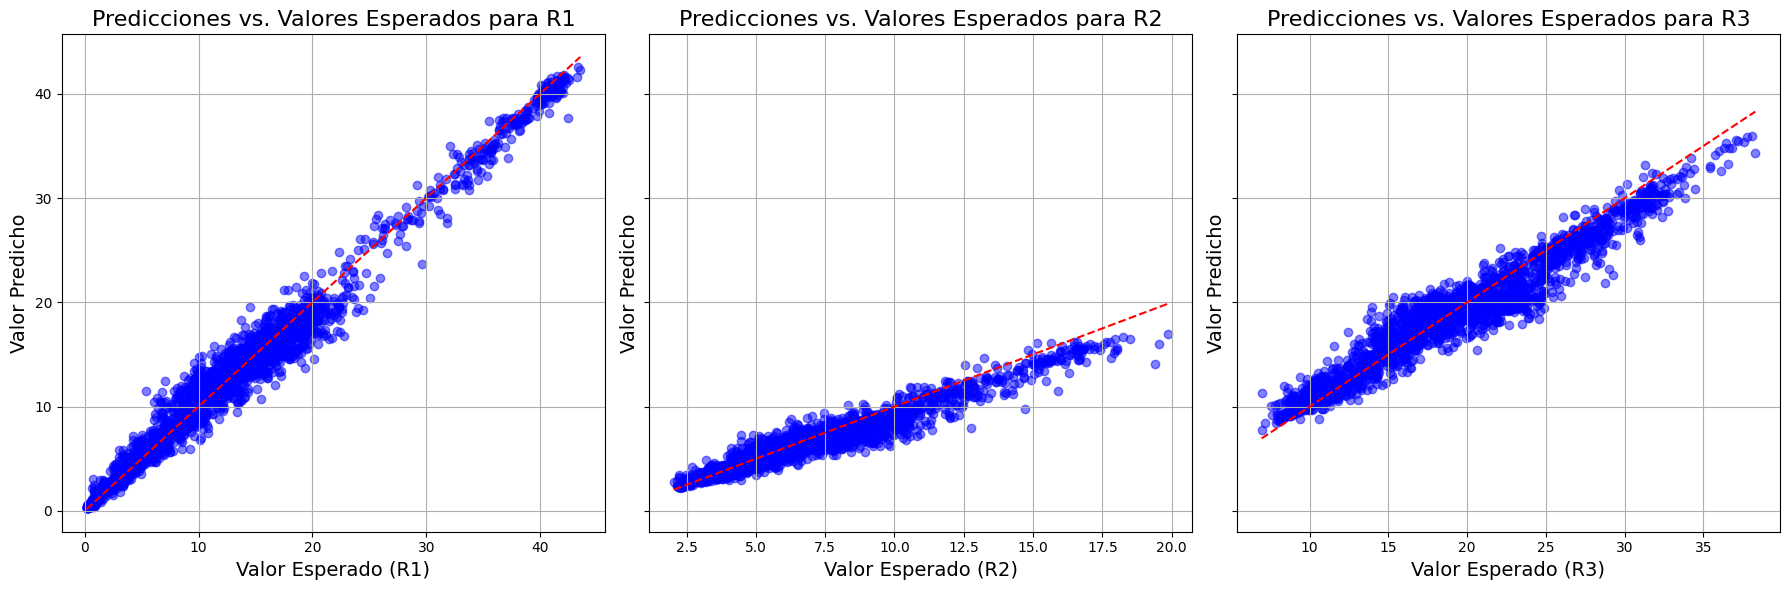

In [27]:
# Crear subgráficos
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Iterar sobre las columnas de predicción
for i, columna in enumerate(['R1', 'R2', 'R3']):
    # Scatter plot de los valores esperados vs. predichos para la columna actual
    axs[i].scatter(predicciones[columna], predicciones[f'P_{columna}'], color='blue', alpha=0.5)
    # Línea diagonal para referencia
    axs[i].plot([predicciones[columna].min(), predicciones[columna].max()], [predicciones[columna].min(), predicciones[columna].max()], color='red', linestyle='--')
    # Título y etiquetas de los ejes
    axs[i].set_title(f'Predicciones vs. Valores Esperados para {columna}', fontsize=16)
    axs[i].set_xlabel(f'Valor Esperado ({columna})', fontsize=14)
    axs[i].set_ylabel('Valor Predicho', fontsize=14)
    # Cuadrícula
    axs[i].grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [28]:
# Métricas
print("-------------------------\nMétricas")
y_pred = meta_predictions
# Calcular R2 ajustado
n = y_test.shape[0] * y_test.shape[1]  # número total de observaciones en y_test
p = X_train.shape[1] # número de características en X_train
r2_aj = r2_ajustado(y_test, y_pred, n, p)

# Métricas de regresión
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE): {:.6f}".format(mse))
print("Mean Absolute Error (MAE): {:.6f}".format(mae))
print("R2 Score: {:.6f}".format(r2))
print("R2 Ajustado: {:.6f}\n".format(r2_aj))

-------------------------
Métricas
Mean Squared Error (MSE): 0.002270
Mean Absolute Error (MAE): 0.034446
R2 Score: 0.936809
R2 Ajustado: 0.934914



/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


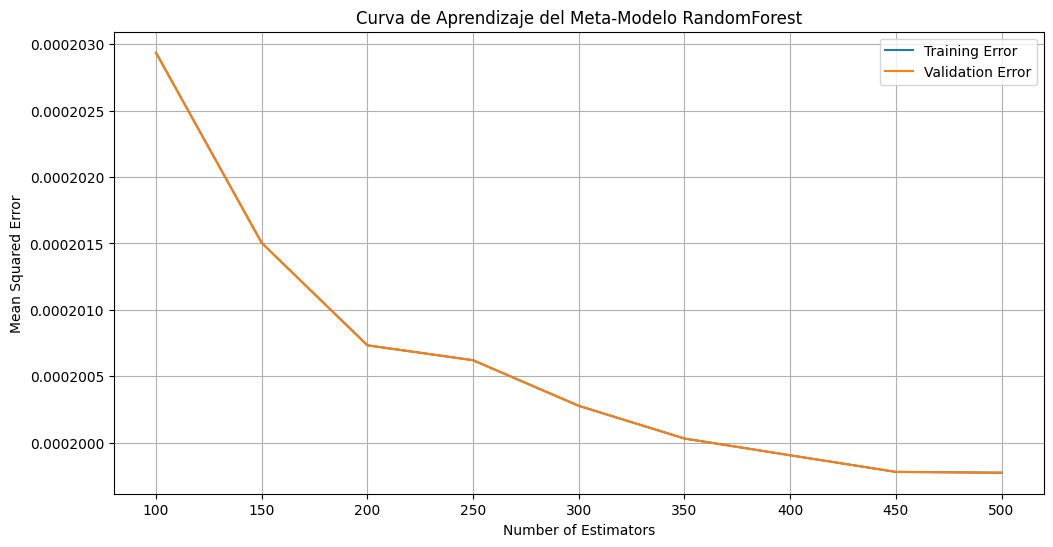

In [29]:
from sklearn.model_selection import cross_val_score

# Función para graficar la curva de aprendizaje del meta-modelo RandomForest
def plot_learning_curve(model, X, y, cv=5):
    """
    Graficar la curva de aprendizaje del modelo.

    Parameters:
    model (sklearn estimator): El modelo a evaluar.
    X (numpy array): Conjunto de características.
    y (numpy array): Conjunto de etiquetas.
    cv (int): Número de pliegues para la validación cruzada.
    """
    train_scores = []
    val_scores = []
    n_estimators_range = range(100, 501, 50)

    for n_estimators in n_estimators_range:
        model.set_params(n_estimators=n_estimators)
        train_scores.append(np.mean(cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)))
        val_scores.append(np.mean(cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)))

    train_scores = np.array(train_scores) * -1  # Convertir a valores positivos
    val_scores = np.array(val_scores) * -1  # Convertir a valores positivos

    plt.figure(figsize=(12, 6))
    plt.plot(n_estimators_range, train_scores, label='Training Error')
    plt.plot(n_estimators_range, val_scores, label='Validation Error')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.title('Curva de Aprendizaje del Meta-Modelo RandomForest')
    plt.grid(True)
    plt.show()

# Llamar a la función para graficar la curva de aprendizaje
plot_learning_curve(meta_model, meta_X_train, y_train)


# Import / Export de Modelos

TensorFlow

In [ ]:
model.save('mlp_model')

In [ ]:
loaded_model = tf.keras.models.load_model('mlp_model')

Pickle

In [ ]:
mlp.save('mlp_model.h5')
with open('mlp_model_pickle.pkl', 'wb') as file:
    pickle.dump('mlp_model.h5', file)

In [ ]:
with open('mlp_model_pickle.pkl', 'rb') as file:
    model_file = pickle.load(file)
loaded_model = tf.keras.models.load_model(model_file)

Joblib

In [ ]:
joblib.dump(mlp, 'mlp_regressor_model.pkl')

['mlp_regressor_model.pkl']

In [ ]:
mlp_loaded = joblib.load('mlp_regressor_model.pkl')